In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate

In [2]:
kc_house_df = pd.read_csv("data/kc_house_data.csv")

In [3]:
kc_house_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


This data has missing values and appears to have default/dummy ones as well.
Not particularly sure how useful Lat/Long will be given that it's all in one area. Probably not usable unless we group it into something resembling neighborhood data.

In [4]:
kc_house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

yr_renovated seems problematic, could be changed to a categorical column of a renovated yes or no. Also possible to look at columns of differences between yr_renovated and date or yr_built. 

In [5]:
date_range = pd.to_datetime(kc_house_df['date'])
print(date_range.max(), date_range.min())
date_range.loc[(date_range.dt.year != 2014) & (date_range.dt.year != 2015)]

2015-05-27 00:00:00 2014-05-02 00:00:00


Series([], Name: date, dtype: datetime64[ns])

We're dealing with a year of sale data, could do some month to month comparisons, or add in columns with categorized data. On intial inspection it appears there are no null or dummy values.

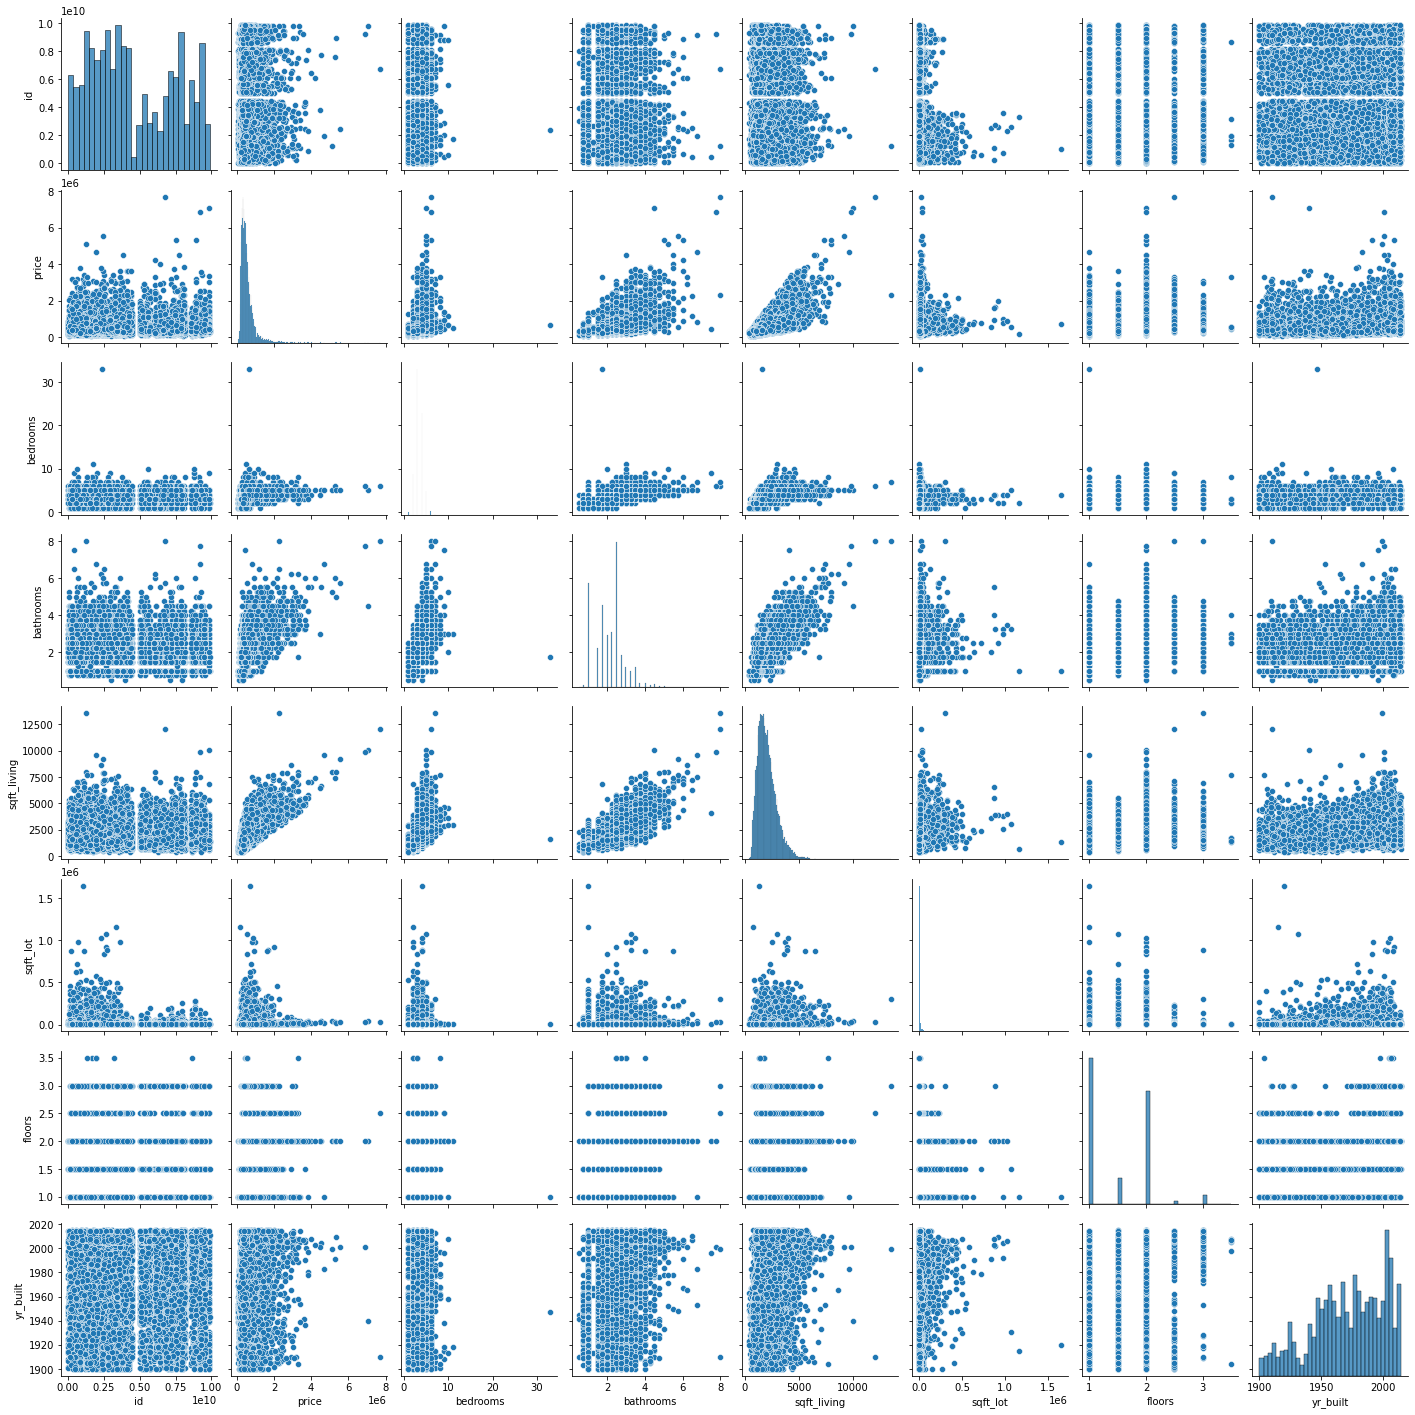

In [6]:
stripped_down_df = kc_house_df.loc[:, ['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'condition', 'grade', 'yr_built']]
sns.pairplot(stripped_down_df) # Pairplot of the recommended columns from the project description. 

<AxesSubplot:>

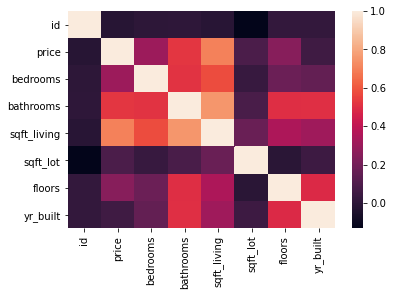

In [7]:
sns.heatmap(stripped_down_df.corr())

## Starting Regressions

A few exploratory models to see what we have to work with.

### Simple Regression

Just using the `sqft_living` column, as that's the one with the highest correlation with price.

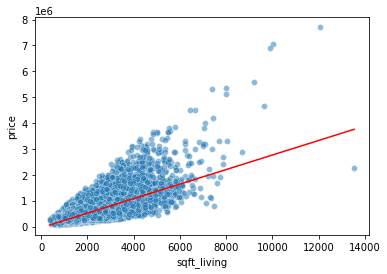

In [8]:
# Get the specific columns out we want for the regression
X = stripped_down_df.loc[:, ['sqft_living']]
y = stripped_down_df.loc[:, ['price']]
plot_data = stripped_down_df.loc[:, ['price', 'sqft_living']]


beginner_reg = LinearRegression()
beginner_reg.fit(X, y)
prediction = beginner_reg.predict(X)

# Plot regression line over scatter plot
fig, ax = plt.subplots()
sns.scatterplot(data=plot_data, x='sqft_living', y='price', ax=ax, alpha=0.5);
sns.lineplot(x=X['sqft_living'], y=prediction[:, 0], ax=ax, color='r');


In [9]:
print(f"R Squared Score: {beginner_reg.score(X, y)}")

R Squared Score: 0.49268789904035093


In [10]:
stats_models_version = sm.OLS(y['price'], sm.add_constant(X)).fit()

In [11]:
stats_models_version.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 2.097e+04
Date:                Tue, 04 Jan 2022   Prob (F-statistic):               0.00
Time:                        15:55:29   Log-Likelihood:            -3.0006e+05
No. Observations:               21597   AIC:                         6.001e+05
Df Residuals:                   21595   BIC:                         6.001e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.399e+04   4410.023     -9.975      0.000   -5.26e+04   -3.53e+04
sqft_living   280.8630      1.939    144.819      0.000     277.062     284.664
==============================================================================
Omnibus:                    14801.942   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           542662.604
Skew:                           2.820   Prob(JB):                         0.00
Kurtosis:                      26.901   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [12]:
inter_df = stripped_down_df.loc[:, ['sqft_living', 'bathrooms', 'bedrooms', 'sqft_lot', 'floors', 'yr_built', 'price']]
X_more = inter_df.drop('price', axis=1)
y_more = inter_df.price

inter_reg = LinearRegression()
inter_reg.fit(X_more, y_more)
print(f"R Squared Score: {inter_reg.score(X_more, y_more)}")
print(f"Coefficients: {inter_reg.coef_}")


R Squared Score: 0.5562851846502235
Coefficients: [ 3.03767349e+02  6.74690231e+04 -6.89999611e+04 -3.01545416e-01
  5.42136300e+04 -3.36761796e+03]


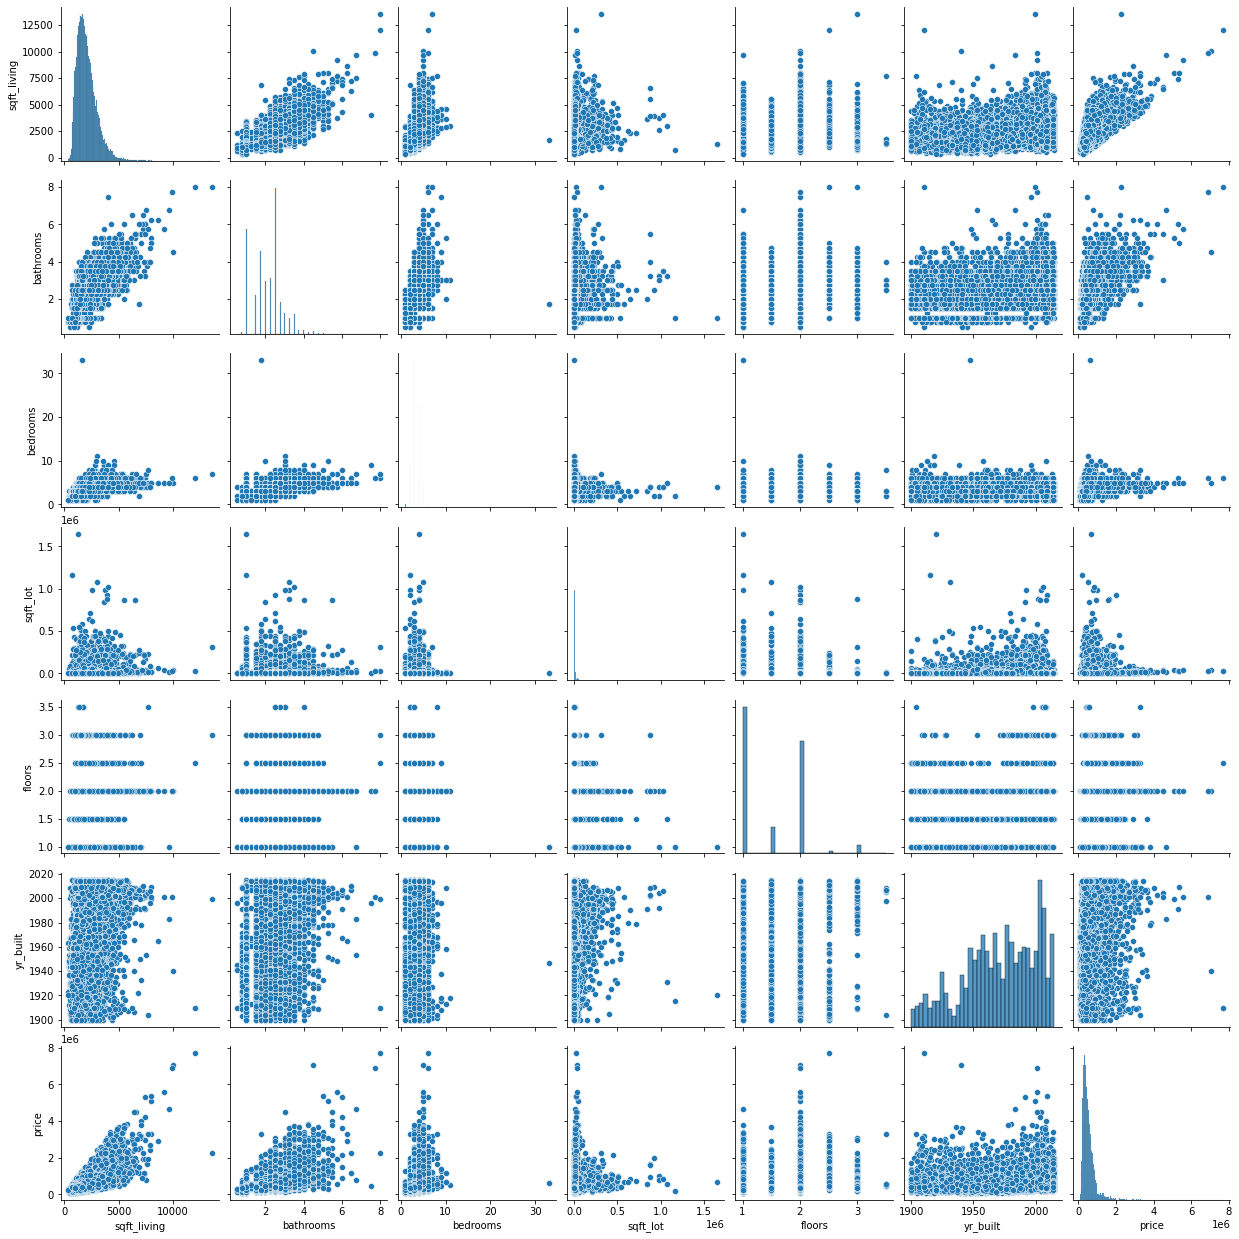

In [13]:
sns.pairplot(inter_df)

In [14]:
stats_models_version_inter = sm.OLS(y_more, sm.add_constant(X_more)).fit()
stats_models_version_inter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     4511.
Date:                Tue, 04 Jan 2022   Prob (F-statistic):               0.00
Time:                        15:56:00   Log-Likelihood:            -2.9862e+05
No. Observations:               21597   AIC:                         5.972e+05
Df Residuals:                   21590   BIC:                         5.973e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        6.559e+06   1.35e+05     48.643      0.000     6.3e+06    6.82e+06
sqft_living   303.7673      3.000    101.249      0.000     297.887     309.648
bathrooms    6.747e+04   3851.524     17.517      0.000    5.99e+04     7.5e+04
bedrooms      -6.9e+04   2253.108    -30.624      0.000   -7.34e+04   -6.46e+04
sqft_lot       -0.3015      0.041     -7.329      0.000      -0.382      -0.221
floors       5.421e+04   3778.051     14.350      0.000    4.68e+04    6.16e+04
yr_built    -3367.6180     70.002    -48.107      0.000   -3504.828   -3230.408
==============================================================================
Omnibus:                    14312.566   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           522258.106
Skew:                           2.680   Prob(JB):                         0.00
Kurtosis:                      26.487   Cond. No.                     3.57e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.57e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:
# Matt's fill nan code

# column_missing_values_dict = {'waterfront': np.NaN, 'view': np.NaN, 'sqft_basement': '?', 'yr_renovated': np.NaN}

# for column_name, missing_value in column_missing_values_dict.items():
#     imputer = SimpleImputer(missing_values=missing_value, strategy='most_frequent')
#     housing_df[column_name] = imputer.fit_transform(housing_df[column_name].values.reshape(-1,1))[:,0]

### Needs Improvement

So far both models have had signs of multicollinearity.

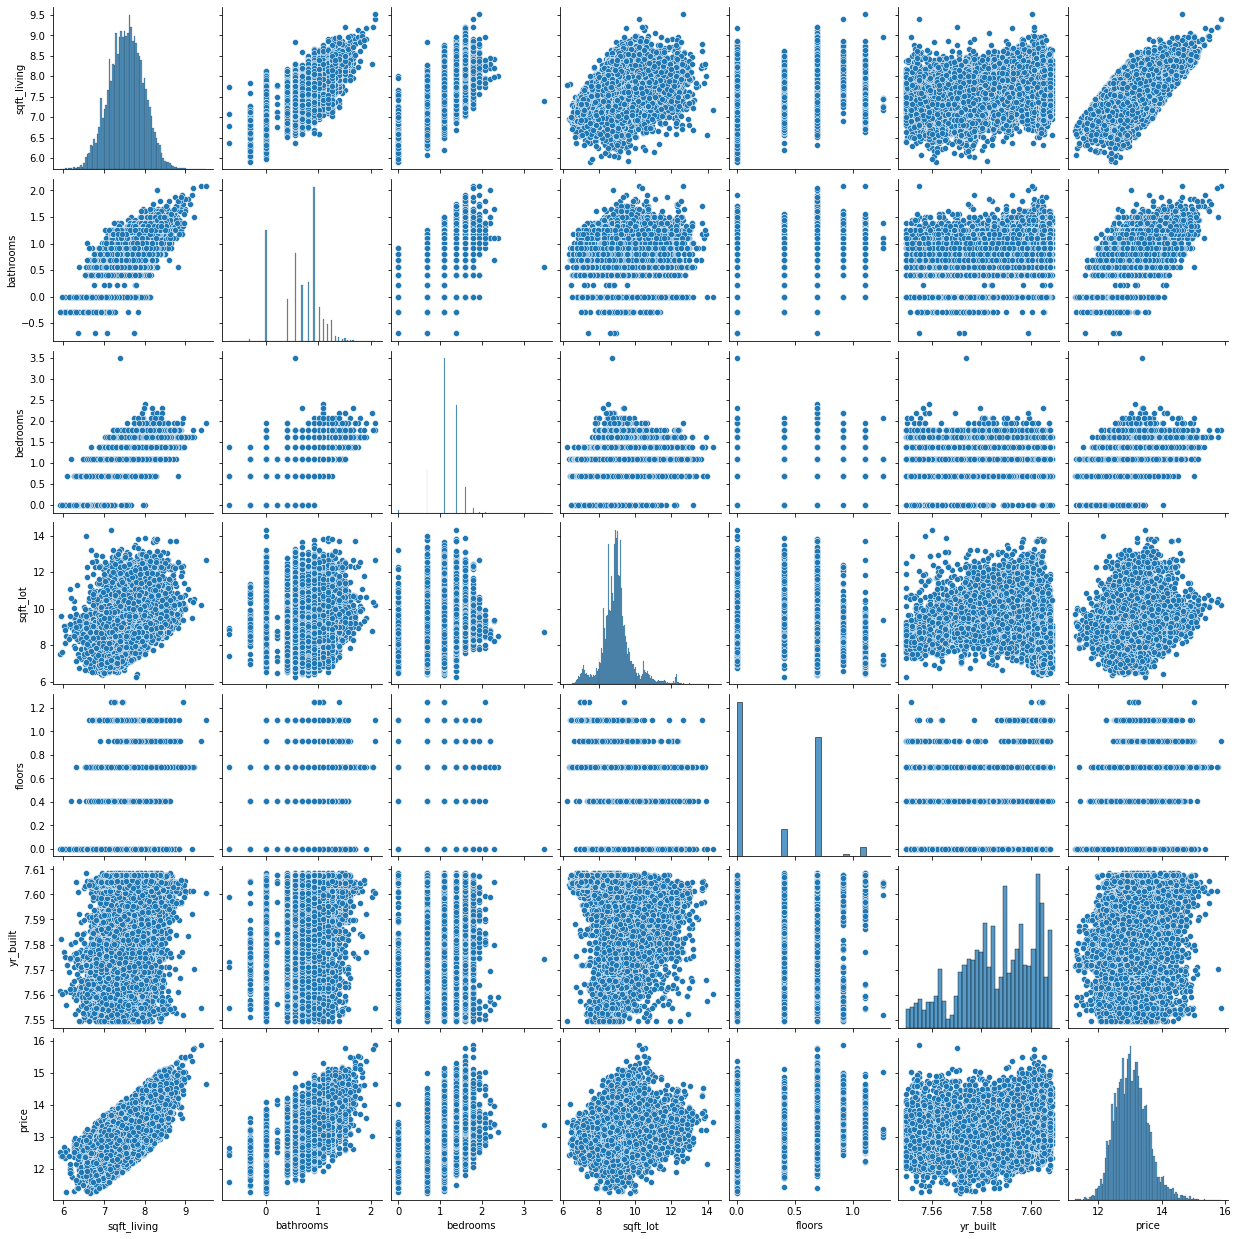

In [16]:
log_inter_df = inter_df.transform(np.log)
sns.pairplot(log_inter_df)

In [19]:
log_inter_df = stripped_down_df.loc[:, ['sqft_living', 'bathrooms', 'bedrooms', 'sqft_lot', 'floors', 'yr_built', 'price']]
X_log = log_inter_df.drop('price', axis=1)
y_log = inter_df.price

log_reg = LinearRegression()
log_reg.fit(X_log, y_log)
print(f"R Squared Score: {log_reg.score(X_log, y_log)}")
print(f"Coefficients: {log_reg.coef_}")

R Squared Score: 0.5562851846502235
Coefficients: [ 3.03767349e+02  6.74690231e+04 -6.89999611e+04 -3.01545416e-01
  5.42136300e+04 -3.36761796e+03]


In [20]:
stats_models_inter_log = sm.OLS(y_log, sm.add_constant(X_log)).fit()
stats_models_inter_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     4511.
Date:                Tue, 04 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:01:08   Log-Likelihood:            -2.9862e+05
No. Observations:               21597   AIC:                         5.972e+05
Df Residuals:                   21590   BIC:                         5.973e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        6.559e+06   1.35e+05     48.643      0.000     6.3e+06    6.82e+06
sqft_living   303.7673      3.000    101.249      0.000     297.887     309.648
bathrooms    6.747e+04   3851.524     17.517      0.000    5.99e+04     7.5e+04
bedrooms      -6.9e+04   2253.108    -30.624      0.000   -7.34e+04   -6.46e+04
sqft_lot       -0.3015      0.041     -7.329      0.000      -0.382      -0.221
floors       5.421e+04   3778.051     14.350      0.000    4.68e+04    6.16e+04
yr_built    -3367.6180     70.002    -48.107      0.000   -3504.828   -3230.408
==============================================================================
Omnibus:                    14312.566   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           522258.106
Skew:                           2.680   Prob(JB):                         0.00
Kurtosis:                      26.487   Cond. No.                     3.57e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.57e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Log transforms appear to have not done much to change R ^ 2 or multicollinearity. Likely better to add some feature columns to improve.

## Train Test Split Versions

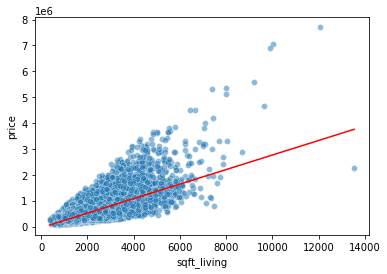

In [ ]:



# Get the specific columns out we want for the regression
X = stripped_down_df.loc[:, ['sqft_living']]
y = stripped_down_df.loc[:, ['price']]
plot_data = stripped_down_df.loc[:, ['price', 'sqft_living']]


beginner_reg = LinearRegression()
beginner_reg.fit(X, y)
prediction = beginner_reg.predict(X)

# Plot regression line over scatter plot
fig, ax = plt.subplots()
sns.scatterplot(data=plot_data, x='sqft_living', y='price', ax=ax, alpha=0.5);
sns.lineplot(x=X['sqft_living'], y=prediction[:, 0], ax=ax, color='r');
